# Instalação e Utilização

**Seguir o README**

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "4" 
import pymc4 as pm
import arviz as az
import matplotlib.pyplot as plt

# Clareza:
* A biblioteca PyMC4 foi desenhada para utilizadores com um bom conhecimento do PyMC3 e TensorFlow, embora exista algumas diferenças significativas na sintax;
* Contudo como é uma biblioteca de Python uma pessoa com algum conhecimento de estatista de de progaramaçãio probabilistica, consegue mais ao menos reconhecer o que está a acontecer.

# Eficiência:
* O PyMC4 baseia se em bibliotecas de TensorFlow e por isso certas bibliotecas como o TensorFlowGPU podem ser usadas para tornar o estudo de certos modelos mais eficiente;
* Contudo se o utilizidador possuir um GPU integrada, uma GPU dedicada já antiga ou uma GPU da AMD não poderá beneficiar desta "otimização" fornecido pela biblioteca do TensorFlow.
* Sem essa "optimização maior partes dos codigos são de demorada execução e podem até mesmo exceder os limites de alguns componente de Hardware

# Distribuições:
* Qualquer distribuição proveniente das bibliotecas de TensorFlow Probability e PyMC3 podem ser usasdas em PyMC4 sem qualquer problema na modalização de problemas atraves do PyMC4.
* Contudo algumas distribuições já estão incluidas na biblioteca de PyMC4 e essas distribuições são as seguintes:
* ## Distribuições Continuas
   * Beta;
   * Cauchy;
   * Chi2;
   * Exponential;
   * Gamma;
   * GeneralizedNormal;
   * Gumbel;
   * HalfCauchy;
   * HalfNormal;
   * InverseGamma;
   * InverseGaussian;
   * Kumaraswamy;
   * Laplace;
   * LogNormal;
   * Logistic;
   * LogitNormal;
   * Moyal;
   * Normal;
   * Pareto,
   * StudentT;
   * Triangular;
   * Uniform;
   * Flat;
   * HalfFlat;
   * VonMises;
   * HalfStudentT;
   * Weibull
   
* ##  Distribuições Discretas:
   * Bernoulli;
   * Binomial;
   * BetaBinomial;
   * DiscreteUniform;
   * Categorical;
   * Geometric;
   * NegativeBinomial;
   * OrderedLogistic;
   * Poisson;
   * ZeroInflatedBinomial;
   * ZeroInflatedNegativeBinomial;
   * ZeroInflatedPoisson;
   * Zipf

## Exemplos

### Distribuição Normal

<AxesSubplot:title={'center':'model/dist'}>

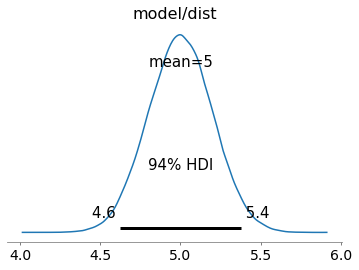

In [2]:
@pm.model
def model(mu, sig):
    dist = yield pm.Normal(loc=mu, scale=sig, name="dist")
    
    return dist

trace = pm.sample(model(5, 0.2), num_samples=8000) # using NUTs

az.plot_posterior(trace, var_names="model/dist")

### Distribuição Exponential

<AxesSubplot:title={'center':'model/dist'}>

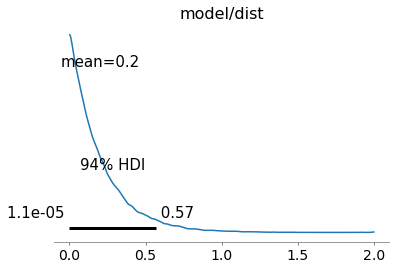

In [3]:
@pm.model
def model(sig):
    dist = yield pm.Exponential(rate=sig, name="dist")
    
    return dist

trace = pm.sample(model(5), num_samples=8000) # using NUTs

az.plot_posterior(trace, var_names="model/dist")

## Métedos de Inferencia (Esta PPL não possui muitos metedos de inferencia):
   *  NUTs (No U Turn Sampler) MCMC (HMC)
   * Variational Inference?? (Não Funciona Direito)

### Vantagens:
   * Usar bibliotecas populares com Tensor Flow e o PyMC3 
       * Temos a vantagem do Tensor Flow (NVidia GPU), podemos correr codigo usando os cudas da GPU
       * Podemos usar maioria dos modelos do PyMC3
       
### Desvantangens: 
   * Pouco eficiente
   * Pouco material disponivel online
   * Não ha uma forma direta de dar polt as distribuições, e necessário usar a biblioteca arviz
   * A PPL já não se encontra em desenvolvimento desde de 29-10-21
   * Os próprios desenvolvedores não aconcelham o uso da PPL

# Tutorial

## Modelo 1:

* Estimar a media e o sigma de um conjunto de dados destribuuidos atraves de uma distribuição normal.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
MU = 10
SIG = 2.2

data = np.random.normal(loc=MU, scale=SIG, size=200)

In [6]:
@pm.model
def model(data):
    mu = yield pm.Normal(loc=0, scale=10, name="mu")
    sig = yield pm.Exponential(rate=0.1, name="sig")
    
    like = yield pm.Normal(loc=mu, scale=sig, observed=data, name="like")
    
    return like

### NUTs

In [7]:
trace = pm.sample(model(data), num_samples=800) # using NUTs

<AxesSubplot:title={'center':'model/mu'}>

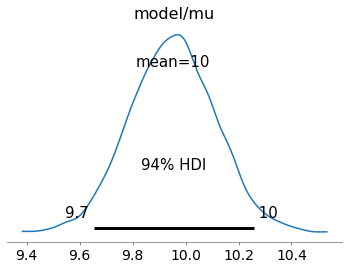

In [8]:
az.plot_posterior(trace, var_names="model/mu")

<AxesSubplot:title={'center':'model/sig'}>

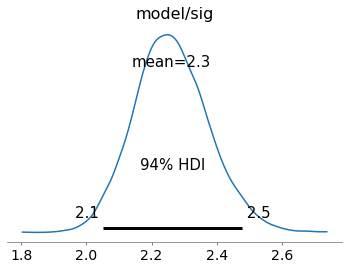

In [9]:
az.plot_posterior(trace, var_names="model/sig")

### Variational Inference
##### Não Funciona como era suposto

<AxesSubplot:title={'center':'model/mu'}>

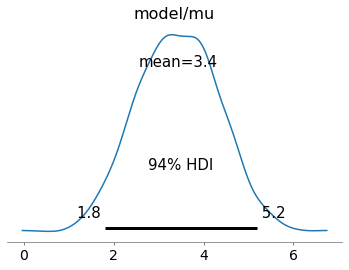

In [10]:
fit = pm.fit(model(data), num_steps=10000, method="advi")
trace = fit.approximation.sample(1000)
az.plot_posterior(trace, var_names=["model/mu"])

Text(0.5, 0, 'Step')

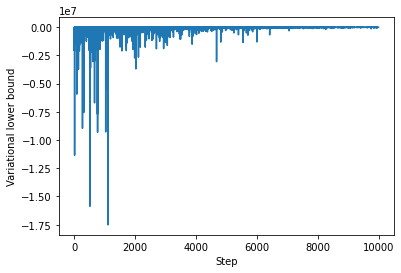

In [11]:
plt.plot(-fit.losses)
plt.ylabel("Variational lower bound")
plt.xlabel("Step")

### Outra forma de expressar o problema

In [12]:
@pm.model
def prior(name, mu=0, sigma=10):
    loc = yield pm.Normal(name, loc=mu, scale=sigma)
    return loc

@pm.model
def sigma_model(name, rate=0.1):
    sigma = yield pm.Exponential(name=name, rate=rate)
    return sigma

@pm.model
def model(x):
    loc = yield prior("mu")
    scale = yield sigma_model("sigma")
    
    obs = yield pm.Normal("obs", loc=loc, scale=scale, observed=x)
    return obs

trace = pm.sample(model(data)) 

### Using NUTs

<AxesSubplot:title={'center':'model/prior/mu'}>

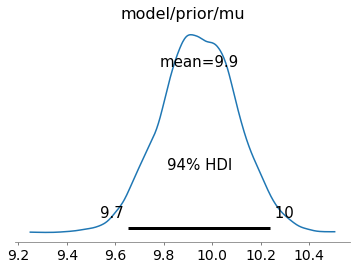

In [13]:
az.plot_posterior(trace, var_names=["model/prior/mu"])   

<AxesSubplot:title={'center':'model/sigma_model/sigma'}>

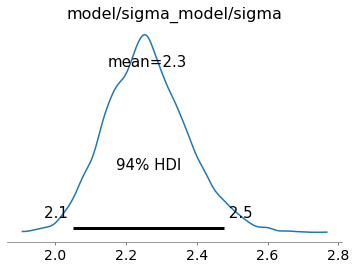

In [14]:
az.plot_posterior(trace, var_names=["model/sigma_model/sigma"])   

## Modelo2

* Descobir a probabilidade de sair cara de um dado conjunto de moedas iguais

In [15]:
data1 = np.random.randint(0,2, 100000)
data2 = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,0]) # 13 caras
@pm.model
def model(data):
    p = yield pm.Uniform("prob", low=0, high=1)
    
    y = yield pm.Bernoulli("y", probs=p, observed=data)

<AxesSubplot:title={'center':'model/prob'}>

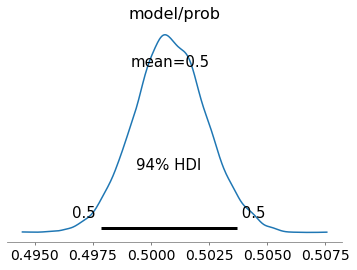

In [16]:
trace = pm.sample(model(data1)) 
az.plot_posterior(trace, var_names=["model/prob"])

<AxesSubplot:title={'center':'model/prob'}>

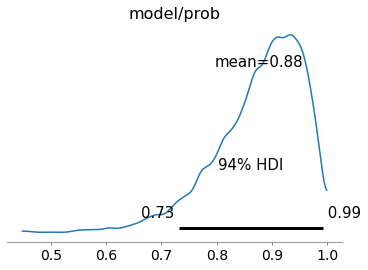

In [17]:
trace = pm.sample(model(data2)) 
az.plot_posterior(trace, var_names=["model/prob"])

In [18]:
def make_coin_rep(num_samples = 10000):
    coins = []
    for i in range(num_samples):
        coin = 1
        count = -1
        while coin == 1:
            count += 1
            coin = np.random.randint(0,2)
        coins += [count]
    return np.array(coins)

data_rep = make_coin_rep()

In [19]:
@pm.model
def ord_model_coin(data):
    p = yield pm.Uniform("prob", low=0, high=1)
    
    obs = yield pm.Geometric("like", probs=p, observed=data)
    
trace = pm.sample(ord_model_coin(data_rep))

<AxesSubplot:title={'center':'ord_model_coin/prob'}>

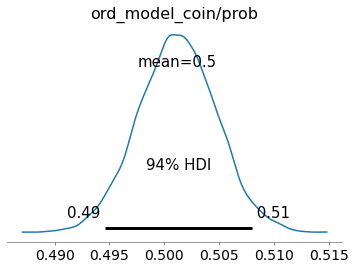

In [20]:
az.plot_posterior(trace, var_names=["ord_model_coin/prob"])

## Modelo3(Previsão do Campeão Nacional)

[REF1: A Hierarchical Bayesian Model of the Premier League](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/)

[REF2: Bayesian hierarchical model for the prediction of
football results](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)

In [21]:
"""
arviz as az
numpy as np
pandas as pd
pymc4 as pm
matplotlib.pyplot as plt
"""
from matplotlib.ticker import PercentFormatter
import tensorflow as tf
from tensorflow_probability import distributions as tfd

In [22]:
df_all = pd.read_csv("data.csv", index_col=0) # Houve um total de 380 jogos (19/20)
df_all

,Round Number,Date,Location,HomeTeam,AwayTeam,Result
Match Number,,,,,,
1,1,18/09/2020 19:00,Estádio Municipal 22 de Junho,FC Famalicão,SL Benfica,1 - 5
2,1,18/09/2020 21:15,Estádio D. Afonso Henriques,Vitória SC,Belenenses SAD,0 - 1
3,1,19/09/2020 16:00,Estádio da Madeira,CD Nacional,Boavista FC,3 - 3
5,1,19/09/2020 21:00,Estádio do Dragão,FC Porto,SC Braga,3 - 1
6,1,20/09/2020 15:00,Estádio de São Miguel,Santa Clara,Marítimo M.,2 - 0
...,...,...,...,...,...,...
135,15,25/01/2021 16:30,Estádio dos Arcos,Rio Ave FC,Santa Clara,1 - 2
129,15,25/01/2021 17:00,Estádio da Luz,SL Benfica,CD Nacional,1 - 1
134,15,25/01/2021 20:15,Estádio de São Luís,SC Farense,FC Porto,0 - 1


In [23]:
teams = df_all.HomeTeam.unique()
teams = pd.DataFrame(teams, columns=["team"])
teams['i'] = teams.index

df = (df_all.merge(teams, left_on="HomeTeam", right_on="team", how="left")
        .rename(columns = {"i": "HomeIdx"})
        .drop('team', 1)
        .merge(teams, left_on="AwayTeam", right_on="team", how="left")
        .rename(columns = {"i": "AwayIdx"})
        .drop("team", 1)
     )

/tmp/ipykernel_2549/1072747796.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = (df_all.merge(teams, left_on="HomeTeam", right_on="team", how="left")


In [24]:
df["HomeScore"] = df["Result"].str.split('-').str[0]
df["AwayScore"] = df["Result"].str.split('-').str[1]
df["HomeScore"] = df["HomeScore"].apply(pd.to_numeric)
df["AwayScore"] = df["AwayScore"].apply(pd.to_numeric)

observed_home_goals = df.HomeScore.values
observed_away_goals = df.AwayScore.values

home_team = df.HomeIdx.values
away_team = df.AwayIdx.values

num_teams = len(teams)
num_games = len(home_team)

g = df.groupby("AwayIdx")
att_starting_points = np.log(g.AwayScore.mean())
def_starting_points = -np.log(g.AwayScore.mean())

In [25]:
home_team = tf.constant(home_team, dtype=tf.int32)
away_team = tf.constant(away_team, dtype=tf.int32)

@pm.model
def premier_model():

    # Parametros globais do modelo
    home = yield pm.Normal("home", loc=0, scale=1)
    sd_att = yield pm.HalfStudentT("sd_att", df=3, scale=2.5)
    sd_def = yield pm.HalfStudentT("sd_def", df=3, scale=2.5)
    intercept = yield pm.Normal("intercept", loc=0, scale=1)

    # Parametros especificos para cada equipa
    atts_star = yield pm.Normal("atts_star", loc=0, scale=sd_att, batch_stack=num_teams)
    defs_star = yield pm.Normal("defs_star", loc=0, scale=sd_def, batch_stack=num_teams)

    atts = yield pm.Deterministic("atts", atts_star - tf.reduce_mean(atts_star))
    defs = yield pm.Deterministic("defs", defs_star - tf.reduce_mean(defs_star))
    home_theta = yield pm.Deterministic("home_theta", tf.math.exp(intercept + home + tf.gather(atts, home_team) + tf.gather(defs, away_team)))
    away_theta = yield pm.Deterministic("away_theta", tf.math.exp(intercept + tf.gather(atts, away_team) + tf.gather(defs, home_team)))

    # likelihood of observed data
    home_points = yield pm.Poisson("home_points", rate=home_theta, observed=observed_home_goals)
    away_points = yield pm.Poisson("away_points", rate=away_theta, observed=observed_away_goals)

In [26]:
data = pm.sample(premier_model(), num_chains=12)

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


In [27]:
data.posterior["premier_model/atts_dim_0"] = teams.team.values
data.posterior["permier_model/defs_dim_0"] = teams.team.values
data.posterior["permier_model/atts_star_dim_0"] = teams.team.values

array([[<AxesSubplot:title={'center':'premier_model/intercept'}>,
        <AxesSubplot:title={'center':'premier_model/intercept'}>],
       [<AxesSubplot:title={'center':'premier_model/home'}>,
        <AxesSubplot:title={'center':'premier_model/home'}>],
       [<AxesSubplot:title={'center':'premier_model/sd_att'}>,
        <AxesSubplot:title={'center':'premier_model/sd_att'}>],
       [<AxesSubplot:title={'center':'premier_model/sd_def'}>,
        <AxesSubplot:title={'center':'premier_model/sd_def'}>]],
      dtype=object)

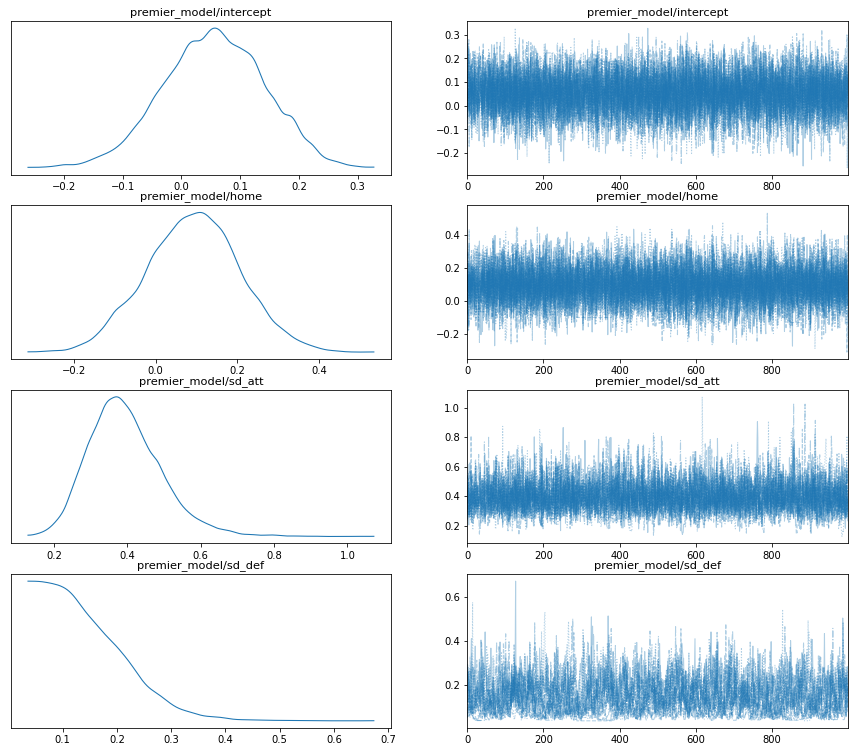

In [28]:
az.plot_trace(data, var_names=["premier_model/intercept", "premier_model/home", "premier_model/sd_att", "premier_model/sd_def"], combined=True, figsize=(15,13))

In [29]:
bfmi = az.bfmi(data)
max_gr = max(np.max(gr_stats) for gr_stats in az.rhat(data).values())

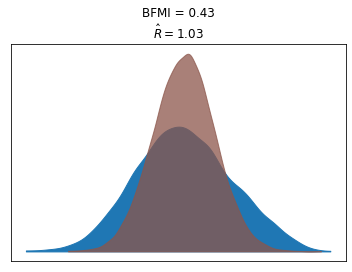

In [30]:
ax = az.plot_energy(data, legend=False, figsize=(6, 4))
ax.set_title(f"BFMI = {np.mean(bfmi):.2f}\n" + "$\hat{R}=$" + f"{max_gr.values:.2f}");

BFMI :: Forma de Calcular quanto informação falta para termos data suficiente para fazer um bom modelo

$\hat{R}$ :: Forma de Medir a Convergência se $\hat{R}>1$ então pelo menos uma chain, ou mais, ainda não convergiram

Não sei pq que no plot da defesa aparece os indices em vez das equipas


Text(0.5, 1.0, 'Team Defense')

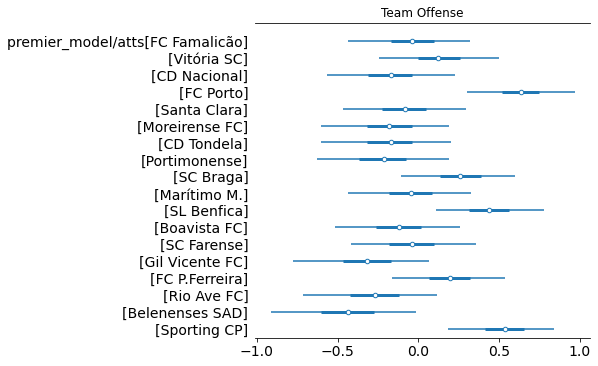

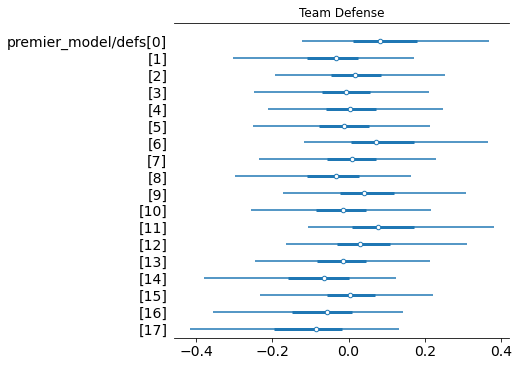

In [31]:
ax = az.plot_forest(data, var_names=["premier_model/atts"], combined=True)
ax[0].set_title('Team Offense')

print("Não sei pq que no plot da defesa aparece os indices em vez das equipas")

ax = az.plot_forest(data, var_names=["premier_model/defs"], combined=True)
ax[0].set_title('Team Defense')

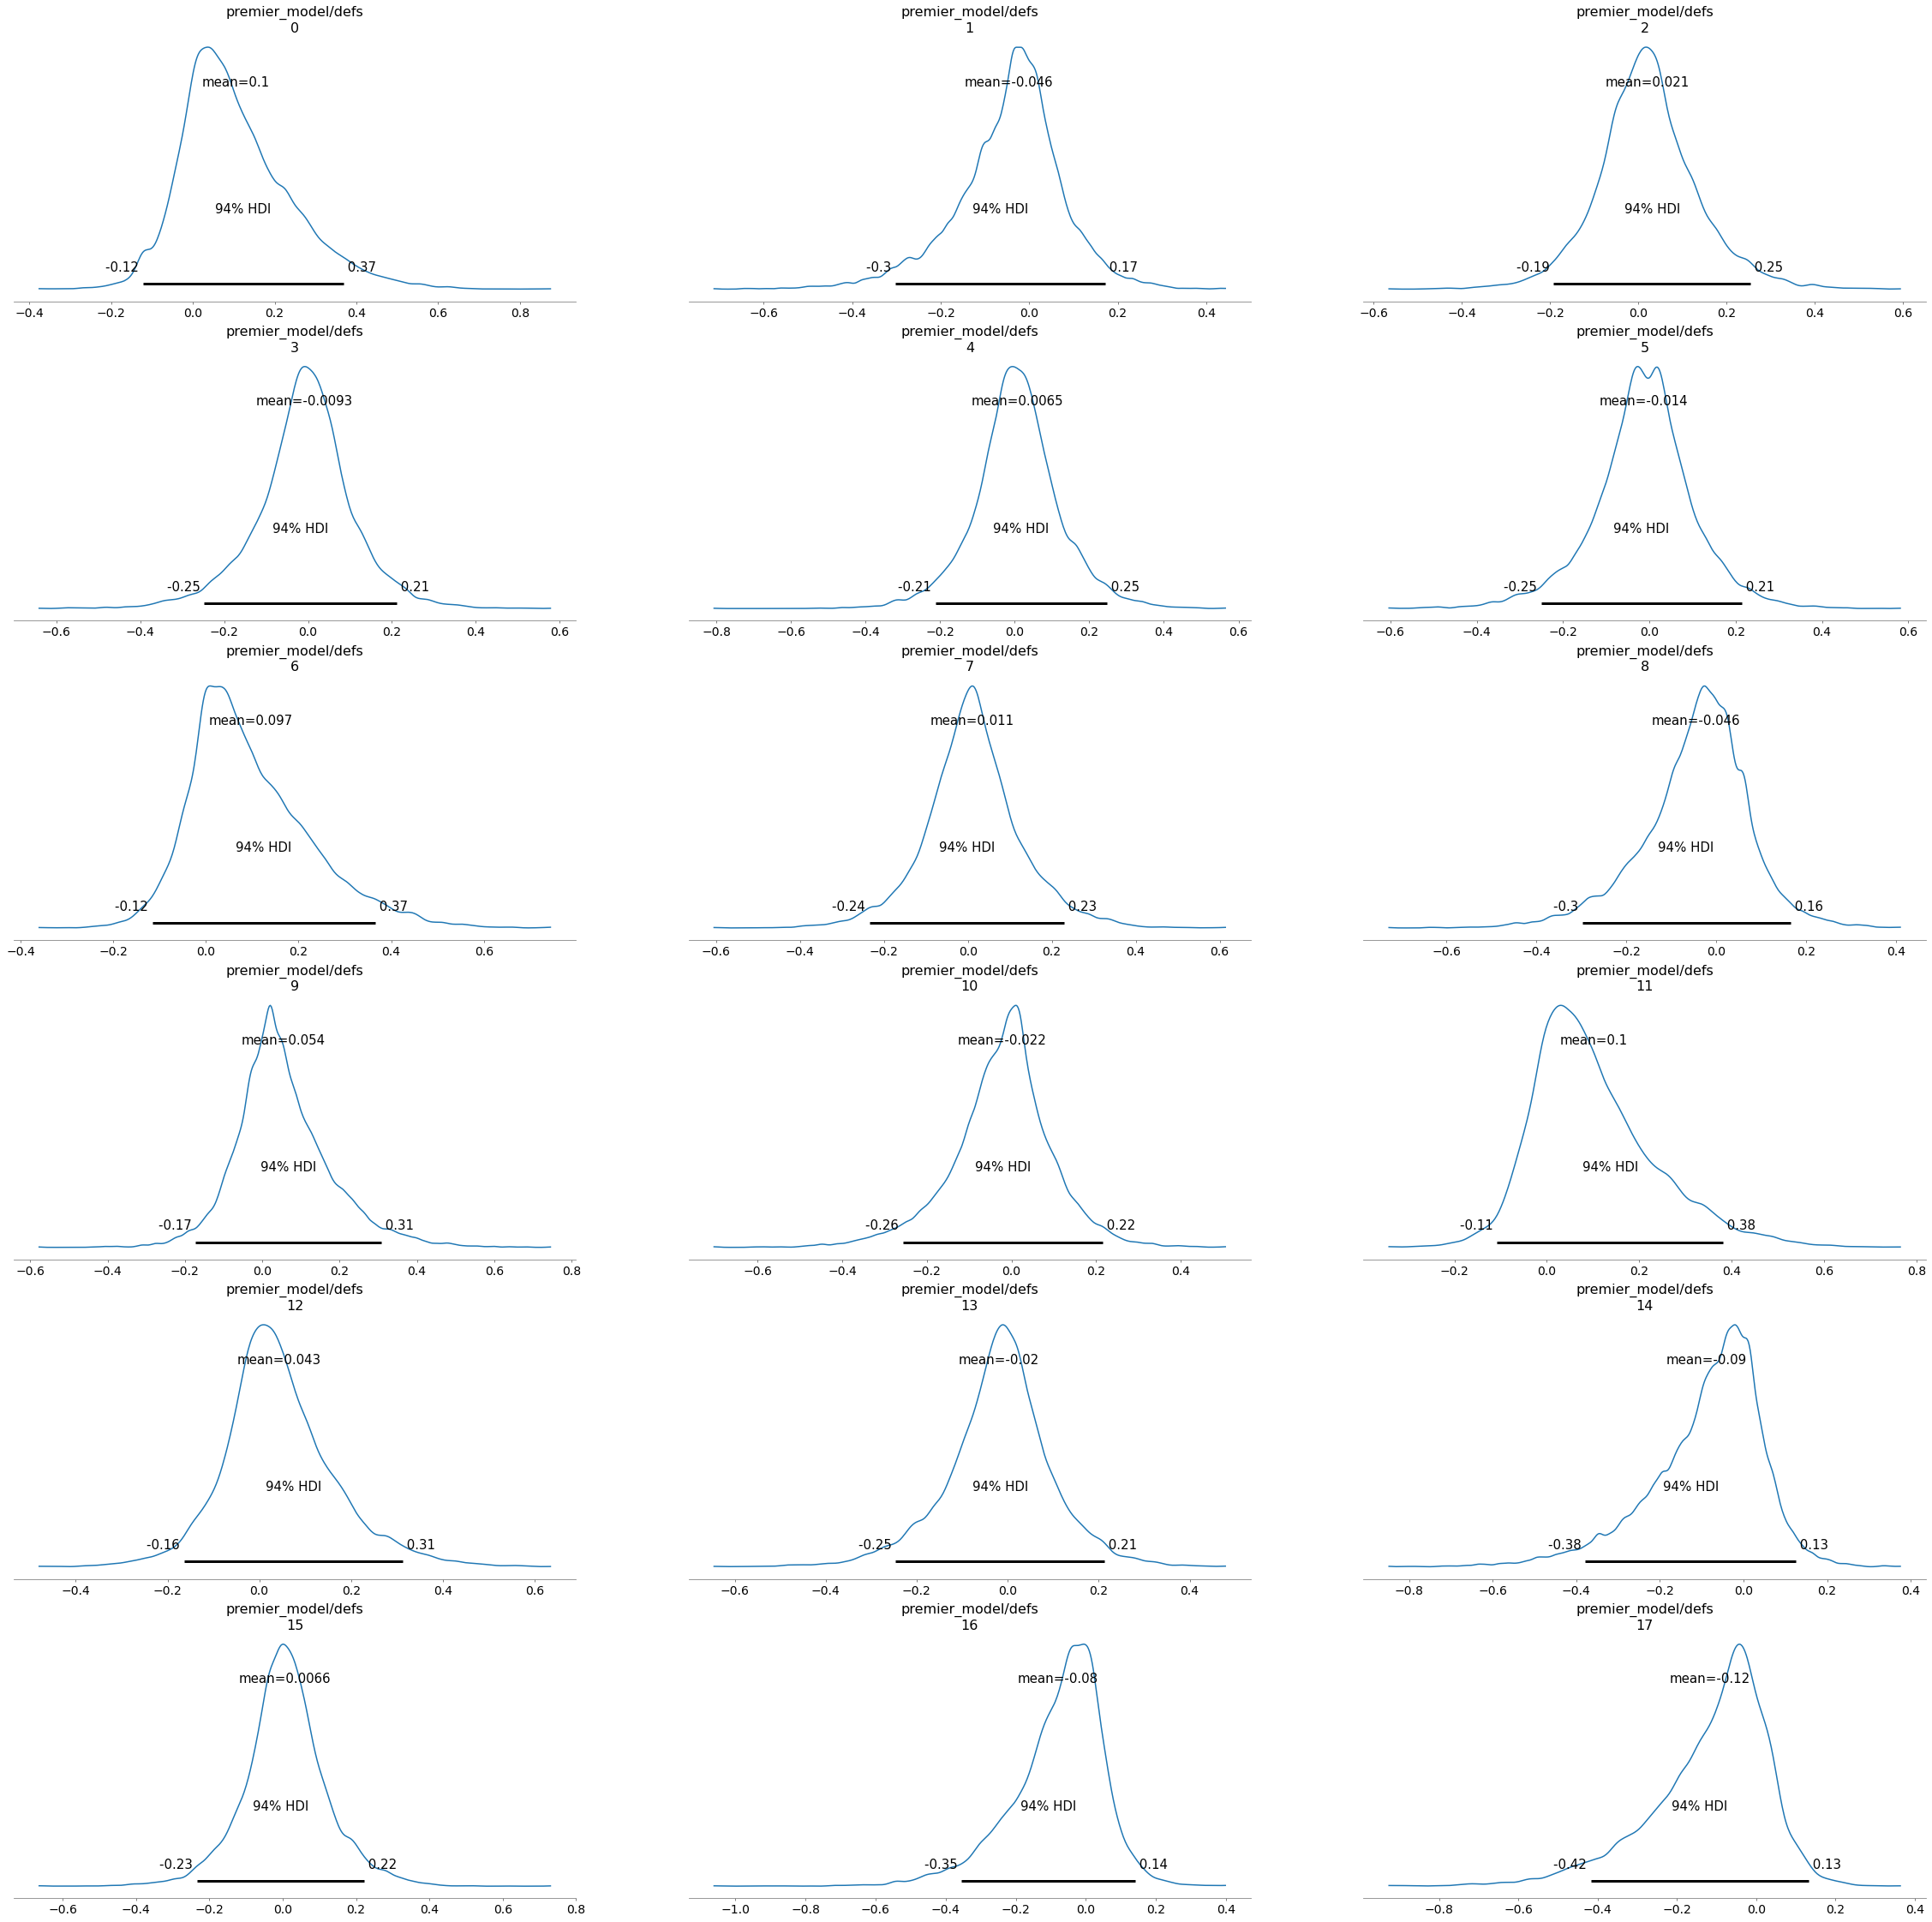

In [32]:
axes = az.plot_posterior(data, var_names=["premier_model/defs"], figsize=(40,40))

In [33]:
pp_trace = pm.sample_posterior_predictive(model=premier_model(), trace=data).posterior_predictive

In [34]:
home_sim_df = pd.DataFrame.from_dict({
    'sim_points_{}'.format(i): 3 * home_won
    for i, home_won in enumerate((pp_trace['premier_model/home_points'] > pp_trace['premier_model/away_points']).values.reshape(-1, df.shape[0]))
})
home_sim_df.insert(0, 'team', df['HomeTeam'])

In [35]:
away_sim_df = pd.DataFrame.from_dict({
    'sim_points_{}'.format(i): 3 * away_won
    for i, away_won in enumerate((pp_trace['premier_model/home_points'] < pp_trace['premier_model/away_points']).values.reshape(-1, df.shape[0]))
})
away_sim_df.insert(0, 'team', df['AwayTeam'])

In [36]:
sim_table = (home_sim_df.groupby('team')
                        .sum()
                        .add(away_sim_df.groupby('team')
                                        .sum())
                        .rank(ascending=False, method='min', axis=0)
                        .reset_index()
                        .melt(id_vars='team', value_name='rank')
                        .groupby('team')['rank']
                        .value_counts()
                        .unstack(level='rank')
                        .fillna(0)
                        .div(pp_trace.dims['chain'] * pp_trace.dims['draw']))
sim_table

rank,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0
team,,,,,,,,,,,,,,,,,,
Belenenses SAD,7.201083,7.816667,6.938417,6.556500,6.939167,7.494833,7.563583,7.708667,7.040000,7.075000,7.514750,7.628417,7.523583,7.719917,7.797417,8.087667,7.808333,7.586000
Boavista FC,5.692750,4.972417,5.261083,6.086333,6.522083,7.039583,7.772833,8.203833,8.119000,7.091417,7.110167,7.581500,7.684833,7.833333,8.194083,8.930667,9.455000,10.449083
CD Nacional,9.413083,10.013917,8.672667,8.173333,8.436417,8.961750,8.811833,8.629333,7.479917,7.313417,7.167417,7.357333,6.739000,6.568917,6.124333,5.438167,4.767417,3.931750
CD Tondela,8.593417,8.883500,7.897250,7.610833,8.074917,8.225417,8.399250,8.157417,7.203000,7.301250,7.499250,7.535917,7.265167,7.203750,6.788583,6.551750,5.743667,5.065667
FC Famalicão,7.501583,7.130667,6.681250,6.953917,7.584917,8.262500,8.650417,8.912333,7.861417,7.654750,8.030667,8.089917,7.677417,7.306500,7.281167,6.831417,6.116583,5.472583
FC P.Ferreira,15.916667,12.190000,10.637083,10.381250,9.844500,9.347833,9.250333,8.917750,8.320750,6.050750,5.599083,5.353583,4.781083,4.339833,3.996000,3.695833,3.141333,2.236333
FC Porto,44.121417,25.069833,15.517583,11.560083,8.628917,6.711417,5.275417,4.246417,3.015167,2.287000,2.005083,1.521500,1.230000,0.881000,0.787750,0.528667,0.395083,0.217667
Gil Vicente FC,3.849583,4.605083,5.564500,6.628917,7.684833,8.965583,9.762833,10.200917,10.256333,7.898083,8.289250,8.394917,8.203333,7.779917,7.462167,7.022750,6.342250,5.088750
Marítimo M.,8.524667,8.245667,8.515417,9.140083,9.109917,9.686667,9.917583,10.099083,9.338083,7.142583,7.267083,6.788583,6.619417,5.767333,5.500083,5.024417,4.121167,3.192167


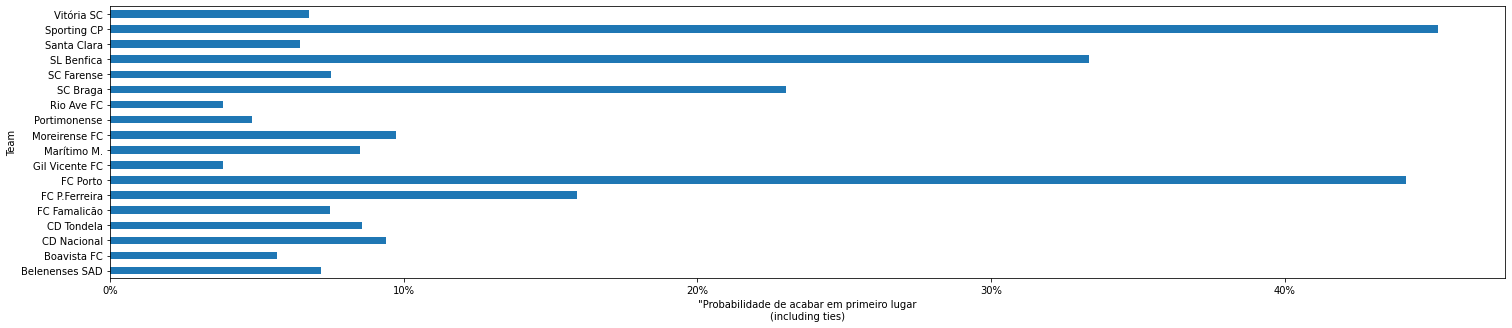

In [37]:
ax = sim_table.loc[:, 1.0].plot(kind='barh', figsize=(25,5))

ax.xaxis.set_major_formatter(PercentFormatter(decimals=0));
ax.set_xlabel("\"Probabilidade de acabar em primeiro lugar\n(including ties)")

ax.set_ylabel("Team");